k近邻（KNN）

KNN分类器分为两个阶段：

1. 在训练阶段，分类器获取训练数据，并记住它;
2. 在测试阶段，knn分类器计算每一张测试集的图片与训练集中所有图片的距离，并导出k个最近的训练样本的类标签;
3. 对k进行交叉验证

In [2]:
# 获取数据
from six.moves import cPickle as pickle
import os
import numpy as np

def load_CIFAR_batch(filename):
    """load single batch of cifar"""
    with open(filename,'rb') as f:
        datadict = pickle.load(f, encoding="latin1")
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X,Y   

filename = '/home/panxie/文档/cs231n/assignment1/cs231n/datasets/cifar-10-batches-py/data_batch_1'
X,Y = load_CIFAR_batch(filename)
print(X.shape)
print(Y.shape)

(10000, 32, 32, 3)
(10000,)


In [29]:
def load_CIFAR(ROOT):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT,'data_batch_%d' % (b,))  ##把目录和文件名合成一个路径
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
        print(np.array(xs).shape)
    print(np.array(xs).shape)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X,Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT,'test_batch'))
    return Xtr,Ytr,Xte,Yte

Xtr,Ytr,Xte,Yte = load_CIFAR('/home/panxie/文档/cs231n/assignment1/cs231n/datasets/cifar-10-batches-py')
print(Xtr.shape)

(1, 10000, 32, 32, 3)
(2, 10000, 32, 32, 3)
(3, 10000, 32, 32, 3)
(4, 10000, 32, 32, 3)
(5, 10000, 32, 32, 3)
(5, 10000, 32, 32, 3)
(50000, 32, 32, 3)


In [30]:
print(Ytr.shape,Yte.shape)

(50000,) (10000,)


In [31]:
print(Ytr[:100])

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3
 7 3 3 5 2 2 7 1 1 1 2 2 0 9 5 7 9 2 2 5 2 4 3 1 1 8 2 1 1 4 9 7 8 5 9 6 7
 3 1 9 0 3 1 3 5 4 5 7 7 4 7 9 4 2 3 8 0 1 6 1 1 4 1]


0 plane
[False False False ..., False False False]
1 car
[False False False ..., False  True  True]
2 bird
[False False False ..., False False False]
3 cat
[False False False ..., False False False]
4 deer
[False False False ..., False False False]
5 dog
[False False False ..., False False False]
6 frog
[ True False False ..., False False False]
7 horse
[False False False ..., False False False]
8 ship
[False False False ..., False False False]
9 truck
[False  True  True ...,  True False False]


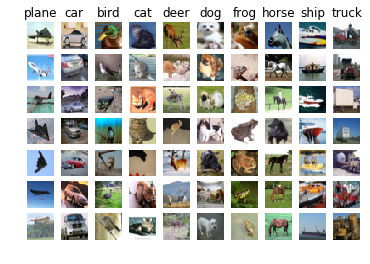

In [32]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
import matplotlib.pyplot as plt
from scipy.misc import imread

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7  #每个类别采样个数
for y,cls in enumerate(classes):  
    print(y,cls)
    print(Ytr == y)   #将Ytr（50000,）里面的元素分别与y进行对比，返回元素为true和false的矩阵
    idxs = np.flatnonzero(Ytr == y)   #找出标签中y类的位置
    idxs = np.random.choice(idxs,samples_per_class,replace=False) #从中随机选出我们所需的7个样本
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class,num_classes,plt_idx)
        plt.imshow(np.uint8(Xtr[idx])) #对应的图像
        plt.axis('off')  #不要轴线
        if i == 0:  #在第一副图上加上标题
            plt.title(cls)
plt.show()


1. enumerate(a)函数：依次返回a中的索引数以及对应的值

2. numpy.flatnonzero(): 该函数输入一个矩阵，返回扁平化后矩阵中非零元素的位置（index）

In [33]:
# Subsample the data for more efficient code execution in this exercise
# 对数据进行子抽样以提高代码执行效率

num_training = 5000
mask = list(range(num_training))
Xtr = Xtr[mask]
Ytr = Ytr[mask]
print(Xtr.shape)

num_test = 500
mask = list(range(num_test))
Xte = Xte[mask]
Yte = Yte[mask]

(5000, 32, 32, 3)


In [34]:
# 还可以这样操作
a = [1,2,3,4,4,5]
b = np.array(a)[[0,1,2,3]]
print(b)

[1 2 3 4]


In [35]:
# Reshape the image data into rows
Xtr = np.reshape(Xtr,(Xtr.shape[0],-1))
Ytr = np.reshape(Ytr,(Ytr.shape[0],-1))
Xte = np.reshape(Xte,(Xte.shape[0],-1))
Yte = np.reshape(Yte,(Yte.shape[0],-1))
print(Xtr.shape,Ytr.shape,Xte.shape,Yte.shape)

(5000, 3072) (5000, 1) (500, 3072) (500, 1)


In [46]:
# knn分类器

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """
    
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
          dists = self.compute_distances_no_loop(X)
        elif num_loops == 1:
          dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
          dists = self.compute_distances_two_loops(X)
        else:
          raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)
    
    def compute_distances_two_loops(self,X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test,num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension.                                    #
                #####################################################################
                dists[i,j] = np.sqrt(np.sum((X[i] - self.X_train[j])**2))
                #####################################################################
                #                       END OF YOUR CODE                            #
                #####################################################################
        return dists
    
    def compute_distances_one_loop(self,X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test,num_train))
        for i in range(num_test):
            dists[i] = np.sqrt(np.sum((self.X_train - X[i]) ** 2, axis=1))
        return dists
    
    def compute_distances_no_loop(self,X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test,num_train))
        dists = np.sqrt((X ** 2).sum(axis=1, keepdims=True) + (self.X_train ** 2).sum(axis=1) - 2 * X.dot(self.X_train.T))
#         dists = np.sqrt(np.sum(X**2,axis=1,keepdims=True)+np.sum(self.X_train**2,axis=1)-2*np.dot(X,self.X_train.T))
        return dists
    
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][:k].reshape(k,)
            ###################################################################
            dict = {}
            for i in closest_y:
                dict[i] = dict.get(i,0)+1
            dict_new = sorted(dict.items(),key=lambda item:item[1],reverse=True)
            y_pred = dict_new[0][0]
            ###################################################################
            #y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred    

计算欧式距离的三种方法，http://blog.csdn.net/zhyh1435589631/article/details/54236643
argsort()函数：返回排序后的索引值，默认从小到大排序

In [47]:
classifier = KNearestNeighbor()
classifier.train(Xtr,Ytr)
dists_no = classifier.compute_distances_no_loop(Xte)
print(dists_no.shape)

y_test_pred = classifier.predict_labels(dists_no,k=1)
num_correct = np.sum(y_test_pred == Yte)
accuracy = float(num_correct)/num_test
print('got %d / %d => accuracy: %f'% (num_correct,num_test,accuracy))

(500, 5000)
got 57 / 500 => accuracy: 0.114000


In [48]:
y_test_pred = classifier.predict_labels(dists_no,k=5)
num_correct = np.sum(y_test_pred == Yte)
accuracy = float(num_correct)/num_test
print('got %d / %d => accuracy: %f'% (num_correct,num_test,accuracy))

got 57 / 500 => accuracy: 0.114000


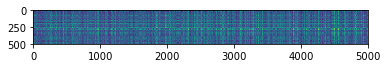

In [49]:
plt.imshow(dists_no,interpolation='none')
plt.show()

In [50]:
# 比较三种距离计算方式的准确率
dists_one = classifier.compute_distances_one_loop(Xte)
print(dists_one.shape)
difference = np.linalg.norm(dists_no - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

(500, 5000)
Difference was: 0.000000
Good! The distance matrices are the same


numpy.linalg.norm()
顾名思义，linalg=linear+algebra，norm则表示范数，首先需要注意的是范数是对向量（或者矩阵）的度量，是一个标量（scalar）.根据ord参数，总共有八种范数。

In [51]:
dists_two = classifier.compute_distances_two_loops(Xte)
print(dists_two.shape)
difference = np.linalg.norm(dists_one - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

(500, 5000)
Difference was: 0.000000
Good! The distance matrices are the same


In [52]:
# Let's compare how fast the implementations are

def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, Xte)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, Xte)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loop, Xte)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 32.313415 seconds
One loop version took 43.712551 seconds
No loop version took 0.270038 seconds


交叉验证
We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [59]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array(np.array_split(Xtr,num_folds))
Y_train_folds = np.array(np.array_split(Ytr,num_folds))
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
print(np.array(X_train_folds).shape)

k_to_accuracies = {}

for k in k_choices:
    for j in range(num_folds):
        train_num = [n for n in range(num_folds) if n != j]
        X_train_cross = np.concatenate(X_train_folds[train_num])
        Y_train_cross = np.concatenate(Y_train_folds[train_num])
        X_val_cross = np.concatenate(X_train_folds[[j]])
        Y_val_cross = np.concatenate(Y_train_folds[[j]])
        classifier = KNearestNeighbor()
        classifier.train(X_train_cross,Y_train_cross)
        y_val_pred = classifier.predict(X_val_cross,k,num_loops=0)
        num_correct = np.sum(y_val_pred == Y_val_cross)
        accuracy = float(num_correct)/num_test
        k_to_accuracies.setdefault(k,[]).append(accuracy)

print(k_to_accuracies)

(5, 1000, 3072)
{1: [0.198, 0.2, 0.194, 0.222, 0.194], 3: [0.214, 0.2, 0.21, 0.222, 0.194], 5: [0.214, 0.208, 0.194, 0.222, 0.194], 8: [0.214, 0.208, 0.194, 0.222, 0.194], 10: [0.214, 0.208, 0.194, 0.222, 0.194], 12: [0.214, 0.208, 0.194, 0.222, 0.194], 15: [0.214, 0.208, 0.194, 0.222, 0.194], 20: [0.214, 0.208, 0.194, 0.222, 0.194], 50: [0.198, 0.208, 0.21, 0.222, 0.194], 100: [0.214, 0.208, 0.21, 0.222, 0.194]}


In [60]:
# Print out the computed accuracies
# for k in sorted(k_to_accuracies):
#     print('k = %d, accuracy = %f' % (k, k_to_accuracies.get(k,)))
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.198000
k = 1, accuracy = 0.200000
k = 1, accuracy = 0.194000
k = 1, accuracy = 0.222000
k = 1, accuracy = 0.194000
k = 3, accuracy = 0.214000
k = 3, accuracy = 0.200000
k = 3, accuracy = 0.210000
k = 3, accuracy = 0.222000
k = 3, accuracy = 0.194000
k = 5, accuracy = 0.214000
k = 5, accuracy = 0.208000
k = 5, accuracy = 0.194000
k = 5, accuracy = 0.222000
k = 5, accuracy = 0.194000
k = 8, accuracy = 0.214000
k = 8, accuracy = 0.208000
k = 8, accuracy = 0.194000
k = 8, accuracy = 0.222000
k = 8, accuracy = 0.194000
k = 10, accuracy = 0.214000
k = 10, accuracy = 0.208000
k = 10, accuracy = 0.194000
k = 10, accuracy = 0.222000
k = 10, accuracy = 0.194000
k = 12, accuracy = 0.214000
k = 12, accuracy = 0.208000
k = 12, accuracy = 0.194000
k = 12, accuracy = 0.222000
k = 12, accuracy = 0.194000
k = 15, accuracy = 0.214000
k = 15, accuracy = 0.208000
k = 15, accuracy = 0.194000
k = 15, accuracy = 0.222000
k = 15, accuracy = 0.194000
k = 20, accuracy = 0.214000
k = 20, accu

array_split(ary,indices_or_sections,axis=0)将数组按顺序拆分成多个子数组。

Python 字典 setdefault() 函数和get() 方法类似, 如果键不存在于字典中，将会添加键并将值设为默认值。

In [55]:
# narray[list]，返回结果是把list当作索引对应的部分
a = np.array([[1,2,3],[2,3,4],[3,4,5],[4,5,6]])
print(a)
print(a[[0,2]])

[[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]]
[[1 2 3]
 [3 4 5]]


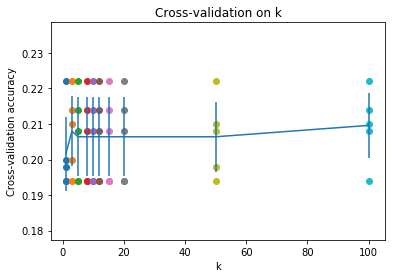

In [61]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)    ##散点图

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

[ 0.198  0.2    0.194  0.222  0.194]
(5,)
[2 4 3 1 2]
(5,)
1.01980390272


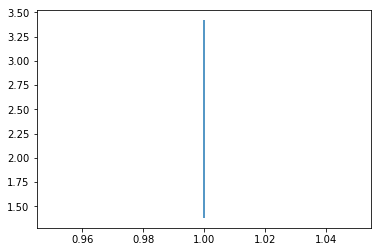

In [107]:
# 绘制误差棒图 plt.errorbar
# 误差棒是以被测量的算术平均值为中点，在表示测量值大小的方向上画出的一个线段，线段长度的一半等于（标准或扩展）不确定度。
# 它表示被测量以某一概率（68%或95%）落在棒上。

k = 1
accuracy_1 = np.array(k_to_accuracies[k])
print(accuracy_1)
print(accuracy_1.shape)

X= np.random.randint(1,5,5)
print(X)
print(X.shape)

# accuracy_k_mean = np.mean(accuracy_1)
# print(accuracy_k_mean)
# accuracy_k_std = np.std(accuracy_1,axis=1)
# print(accuracies_std)                   #??????????????????????????????????????????????
# plt.errorbar(k,accuracy_k_mean,accuracies_std,fmt='-o')

X_mean = np.mean(X)
X_std = np.std(X)
print(X_std)
plt.errorbar(1,X_mean,X_std)



plt.show()

In [89]:
best_k = 100

classifier = KNearestNeighbor()
classifier.train(Xtr, Ytr)
y_test_pred = classifier.predict(Xte, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == Yte)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 57 / 500 correct => accuracy: 0.114000
